In [49]:
import os.path as osp
from utils import *
import mmcv
import torch
import wandb
from mmcv import Config
from mmcv.parallel import MMDistributedDataParallel
from mmdet.apis import set_random_seed, train_detector
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from algo2_result_to_aligned_result import algo2_result_to_aligned_result
# Let's take a look at the dataset image
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from xml_to_np import xml_to_np
from AP import calc_iou_individual, get_single_image_results
from soft_nms import py_cpu_softnms
from dbscan_result_to_aligned_result import dbscan_result_to_aligned_result
from AP import calc_iou_individual
import xml.etree.ElementTree as ET
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import cv2

In [3]:
checkpoint_file = '/home/aiarhipov/centernet/exps/16_paper_params_dla34_batch8/epoch_150.pth'

config_file = "/home/aiarhipov/centernet/exps/16_paper_params_dla34_batch8/config.py"
cfg = Config.fromfile(config_file)

set_random_seed(0, deterministic=False)

dataset = build_dataset(cfg.data.test)

model = build_detector(cfg.model)
model.CLASSES = dataset.CLASSES

model = init_detector(config_file, checkpoint_file, device='cuda:6')

loading annotations into memory...
Done (t=4.33s)
creating index...
index created!


2023-04-22 23:10:26,215 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2023-04-22 23:10:26,217 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2023-04-22 23:10:26,220 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


load checkpoint from local path: /home/aiarhipov/centernet/exps/16_paper_params_dla34_batch8/epoch_150.pth


In [4]:
conf_threshold = 0.5
iou_threshold = 0.9
res = []
# for idx in tqdm(range(int(len(dataset)))):
idx = 7
anno = dataset.get_ann_info(idx=idx)
boxes = anno["bboxes"]
segm_path = anno["seg_map"]
xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"

gt_boxes = xml_to_np(xml_path)
# print(f"gt_boxes[0] = {gt_boxes[:5]}")
pred = inference_detector(model, img_path)[0]
# print(f"pred[0] = {pred[:5]}")
conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
# print(f"conf_indexes = {conf_indexes}")
conf_pred = pred[conf_indexes]
# print(f"conf_pred[0] = {conf_pred[:5]}")
if conf_pred.shape[0] > 1:
    conf_pred = dbscan_result_to_aligned_result([conf_pred])
    if conf_pred:
        conf_pred = conf_pred[0]
        print(gt_boxes[:, :4].shape)
        print(conf_pred[:, :4].shape)

(92, 4)
(87, 4)


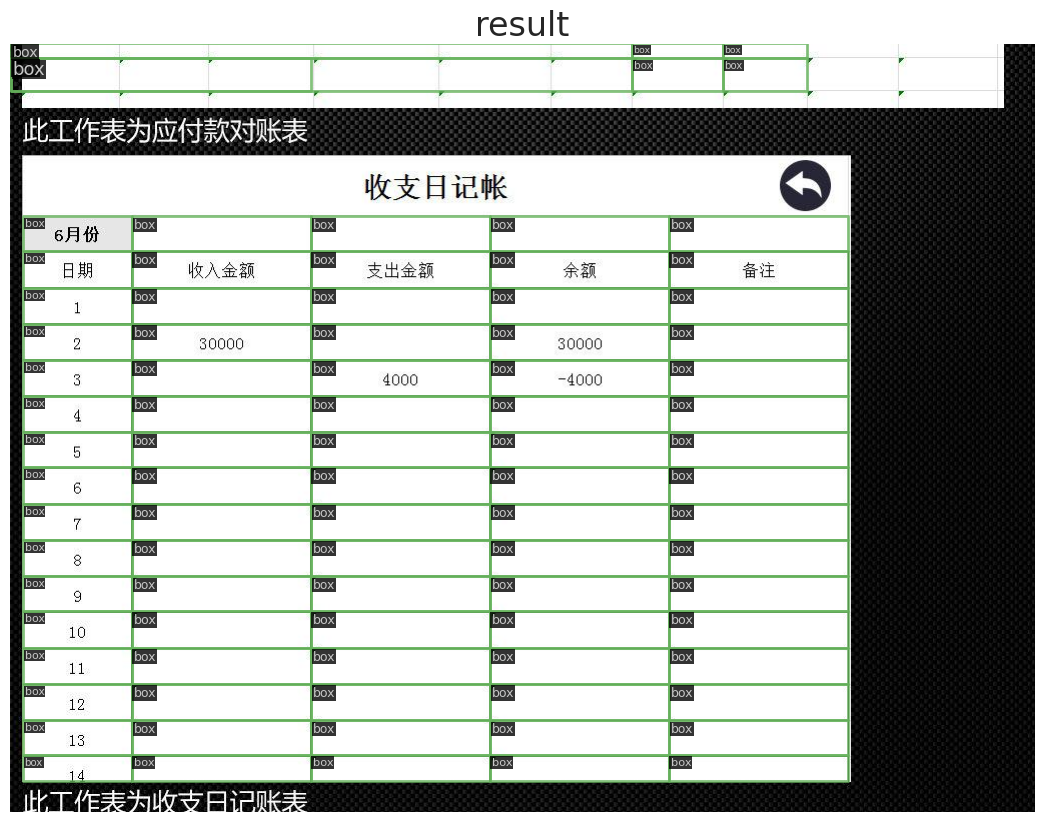

In [7]:
show_result_pyplot(model, img_path, [conf_pred[:, :4]], score_thr = 0)

In [52]:
def LC_for_dbscan_algo(pred):
    res = np.pad(pred, ((0,0),(0,4)), mode="constant", constant_values=np.nan)
    # left_edge.append(((box[0], box[1]), (box[0], box[3])))
    # right_edge.append(((box[2], box[1]), (box[2], box[3])))
    # up_edge.append(((box[0], box[1]), (box[2], box[1])))
    # down_edge.append(((box[0], box[3]), (box[2], box[3])))
    x = np.unique(np.hstack((pred[:, 0], pred[:, 2])))
    y = np.unique(np.hstack((pred[:, 1], pred[:, 3])))
    for idx, box in enumerate(pred):
        startrow = np.where(np.isclose(y, box[1]))[0][0]
        endrow = np.where(np.isclose(y, box[3]))[0][0] - 1
        startcolumn = np.where(np.isclose(x, box[0]))[0][0]
        endcolumn = np.where(np.isclose(x, box[2]))[0][0] - 1
        res[idx, -1] = endcolumn
        res[idx, -2] = startcolumn
        res[idx, -3] = endrow
        res[idx, -4] = startrow
    return res
    
# print_LC(img_path, LC_for_dbscan_algo(conf_pred))

In [67]:
def adjacency_relation_per_image_dbscan(gt, pred, iou_threshold=0) -> dict:
    """_summary_

    Parameters
    ----------
    gt : shape(n, 4) xmin, ymin, xmax, ymax, [match], startrow, endrow, startcol, endcol
        _description_
    pred : shape(n, 5) xmin, ymin, xmax, ymax, confidence, [startrow, endrow, startcol, endcol]
        _description_
    """
    pred = LC_for_dbscan_algo(pred)
    matched_gt = np.insert(gt, 4, np.nan, axis=1)
    for idx, g in enumerate(gt):
        iou = pd.Series([calc_iou_individual(p[:4], g[:4]) for p in pred])
        max_idx = iou.argmax()
        max_idx = max_idx if iou[max_idx] > iou_threshold else np.nan
        matched_gt[idx, 4] = max_idx
    
    for idx, g in enumerate(matched_gt):
        if g[4]:
            anchor_pred_idx = g[4]
            gt_h_next_idx = matched_gt[np.where((matched_gt[:,7] == g[8]+1) & (matched_gt[:,5] == g[5]))][0, 4]
            gt_v_next_idx = matched_gt[np.where((matched_gt[:,5] == g[6]+1) & (matched_gt[:,7] == g[7]))][0, 4]
            if gt_h_next_idx:
                pred_h_next_idx, = np.where((pred[:,7] == pred[anchor_pred_idx, 8] + 1) & (pred[:,5] == g[5]))
                if (pred[pred_h_next_idx, :4] == matched_gt[gt_h_next_idx, :4]).all():
                    tp +=1
                 
            if gt_v_next_idx:
                pred_v_next_idx, = np.where((pred[:,5] == pred[anchor_pred_idx, 6] + 1) & (pred[:,7] == g[7]))
                if (pred[pred_v_next_idx, :4] == matched_gt[gt_v_next_idx, :4]).all():
                    tp +=1
    return pred
adjacency_relation_per_image_dbscan(gt_boxes, conf_pred, iou_threshold=0.5)

array([[ 11.,  15., 109.,  47.,  nan,   0.,   0.,   0.,   0.],
       [108.,  15., 198.,  47.,  nan,   0.,   0.,   1.,   1.],
       [197.,  15., 304.,  47.,  nan,   0.,   0.,   2.,   2.],
       [303.,  15., 428.,  47.,  nan,   0.,   0.,   3.,   3.],
       [427.,  14., 539.,  48.,  nan,   0.,   0.,   4.,   4.],
       [539.,  14., 621.,  48.,  nan,   0.,   0.,   5.,   5.],
       [621.,  14., 711.,  48.,  75.,   0.,   0.,   6.,   6.],
       [711.,  14., 798.,  48.,  64.,   0.,   0.,   7.,   7.],
       [797.,  14., 888.,  48.,  nan,   0.,   0.,   8.,   8.],
       [887.,  14., 986.,  48.,  nan,   0.,   0.,   9.,   9.],
       [985.,  14., 993.,  48.,  nan,   0.,   0.,  10.,  10.],
       [ 12., 111., 840., 172.,  nan,   0.,   0.,   0.,   4.],
       [ 12., 172., 122., 208.,  67.,   1.,   1.,   0.,   0.],
       [122., 172., 301., 208.,  57.,   1.,   1.,   1.,   1.],
       [301., 171., 479., 208.,  23.,   1.,   1.,   2.,   2.],
       [479., 171., 658., 208.,  54.,   1.,   1.,   3.,

In [73]:
a = np.array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])
a[np.where(a[:, 2] > 5)]

array([[ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])